In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.linalg as linalg
import os
import time
from lib.ParticleFilter import sample_normal_model, single_step_particle_filter, normal_model_pdf, single_step_particle_filter_measurement_window
from utils.plotting import draw_ellipse, images_to_gif
from utils.filesTools import get_exp_folder

In [2]:

## setup params
NUM_OF_BEACONS = 4
NUM_OF_AGENTS = 1
STATE_SIZE_2D = 2
SINGLE_RANGE_MEASUREMENT_SIZE = 1
RANGE_MEASUREMENT_SIZE = NUM_OF_BEACONS * SINGLE_RANGE_MEASUREMENT_SIZE * NUM_OF_AGENTS
TOTAL_STATE_SIZE = NUM_OF_AGENTS * STATE_SIZE_2D + NUM_OF_BEACONS * STATE_SIZE_2D
NOTE = 'single_beacon'
sigma_transition_agent = 0.5
sigma_transition_beacon = 0.3
sigma_measurement = 0.1
stepsize = 2
n_steps = 150
n_particles = 100
# model definition
cov_measurement = np.diag([sigma_measurement**2 for i in range(RANGE_MEASUREMENT_SIZE)])
cov_transition_agent = [sigma_transition_agent**2 for i in range(NUM_OF_AGENTS*STATE_SIZE_2D)]
cov_transition_agent = [0 for i in range(NUM_OF_AGENTS*STATE_SIZE_2D)]
cov_transition_beacon = [sigma_transition_beacon**2 for i in range(NUM_OF_BEACONS*STATE_SIZE_2D)]
# cov_transition_beacon = [0 for i in range(NUM_OF_BEACONS*STATE_SIZE_2D)]
# cov_transition_beacon[0:6] = [sigma_transition_beacon**2]*6
cov_transition = np.diag(cov_transition_agent + cov_transition_beacon)


In [3]:
# state manger
get_agent_index = lambda i: slice(i*STATE_SIZE_2D, i*STATE_SIZE_2D + STATE_SIZE_2D)
get_beacon_index = lambda i: slice(STATE_SIZE_2D*NUM_OF_AGENTS + i*STATE_SIZE_2D, STATE_SIZE_2D*NUM_OF_AGENTS + i*STATE_SIZE_2D + STATE_SIZE_2D)
get_agent_position = lambda x, i: x[get_agent_index(i)]
get_beacon_postion = lambda x, j: x[get_beacon_index(j)]
def state_to_agent_and_beacons_pos(x):
    agents_pos = np.zeros((NUM_OF_AGENTS, STATE_SIZE_2D))
    beacons_pos = np.zeros((NUM_OF_BEACONS, STATE_SIZE_2D))
    for i in range(NUM_OF_AGENTS):
        agents_pos[i] = get_agent_position(x, i)
    for j in range(NUM_OF_BEACONS):
        beacons_pos[j] = get_beacon_postion(x, j)
    return agents_pos, beacons_pos
def agent_and_beacons_pos_to_state(agents_pos, beacons_pos):
    x = np.zeros(TOTAL_STATE_SIZE)
    for i in range(NUM_OF_AGENTS):
        x[get_agent_index(i)] = agents_pos[i]
    for j in range(NUM_OF_BEACONS):
        x[get_beacon_index(j)] = beacons_pos[j]
    return x

In [4]:
# functions for model
propagate_state = lambda x, u: x + sample_normal_model(u, cov_transition)

def calculate_true_range_meas(x):
    z = np.zeros(RANGE_MEASUREMENT_SIZE)
    for i in range(NUM_OF_AGENTS):
        current_agent_position = x[get_agent_index(i)]
        for j in range(NUM_OF_BEACONS):
            current_beacon_position = x[get_beacon_index(j)]
            z[i*NUM_OF_BEACONS + j] = np.linalg.norm(current_agent_position - current_beacon_position)
    return z

def measurements_model(x, cov = cov_measurement):
    return calculate_true_range_meas(x) + sample_normal_model(np.zeros(RANGE_MEASUREMENT_SIZE), cov)

measurements_likelihood = lambda z, x: normal_model_pdf(z, calculate_true_range_meas(x), cov_measurement)

In [5]:
## test models  
if 0:
    x = np.array([0, 0, 1, 0, 2, 0, 3, 0, 4, 0])*100
    u = np.zeros(TOTAL_STATE_SIZE)
    print(measurements_model(x))
    print(propagate_state(x, u))
## test conversion functions
if 0:
    x = np.array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])
    agents_pos, beacons_pos = state_to_agent_and_beacons_pos(x)
    print(agents_pos, beacons_pos)
    print(agent_and_beacons_pos_to_state(agents_pos, beacons_pos))

In [6]:
## generate ground truth
agent_position_0 = np.array([0,0])
becons_1_position_0 = np.array([10,10])
becons_2_position_0 = np.array([-10,10])
becons_3_position_0 = np.array([10,-10])
becons_4_position_0 = np.array([-10,-10])
x_0 = agent_and_beacons_pos_to_state([agent_position_0], [becons_1_position_0, becons_2_position_0, becons_3_position_0, becons_4_position_0])

#genrate u  commend vector
u = (np.random.rand(TOTAL_STATE_SIZE, n_steps) - 0.5) * stepsize
u = np.zeros((TOTAL_STATE_SIZE, n_steps))
u[get_agent_index(0),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize
u[get_beacon_index(0),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
u[get_beacon_index(1),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
u[get_beacon_index(2),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
u[get_beacon_index(3),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
## create ground truth
x = np.zeros((TOTAL_STATE_SIZE, n_steps))
x[:,0] = x_0
z = np.zeros((RANGE_MEASUREMENT_SIZE, n_steps))
z[:,0] = measurements_model(x[:,0])
for i in range(1, n_steps):
    x[:,i] = propagate_state(x[:,i-1], u[:,i-1])
    z[:,i] = measurements_model(x[:,i])

## plot ground truth
if 0:
    fig, ax = plt.subplots()
    ax.plot(x[0,:], x[1,:], 'r')
    ax.plot(x[2,:], x[3,:], 'g')
    ax.plot(x[4,:], x[5,:], 'b')
    ax.plot(x[6,:], x[7,:], 'y')
    ax.plot(x[8,:], x[9,:], 'm')
    plt.show()


In [7]:
def calculate_linear_measurement_matrix(agent, beacon):
    range = np.linalg.norm(agent - beacon)
    H = np.zeros((1, 2*STATE_SIZE_2D))
    H[0,0] = (agent[0] - beacon[0])/range
    H[0,1] = (agent[1] - beacon[1])/range 
    H[0,2] = (beacon[0] - agent[0])/range
    H[0,3] = (beacon[1] - agent[1])/range
    return H

def total_linear_measurement_matrix(x):
    H = np.zeros((RANGE_MEASUREMENT_SIZE, TOTAL_STATE_SIZE))
    for i in range(NUM_OF_AGENTS):
        agent_position = get_agent_position(x, i)
        for j in range(NUM_OF_BEACONS):
            beacon_position = get_beacon_postion(x, j)
            h = calculate_linear_measurement_matrix(agent_position, beacon_position)
            H[i*NUM_OF_BEACONS + j, get_agent_index(i)] = h[0,0:2]
            H[i*NUM_OF_BEACONS + j, get_beacon_index(j)] = h[0,2:4]
    return H

def calculate_observability_matrix(A,H):
    n = A.shape[0]
    m = H.shape[0]
    O = np.zeros((n*m, n))  
    O[0:m,0:n] = H
    for i in range(1,n):
        O[i*m:(i+1)*m,0:n] = O[(i-1)*m:i*m,0:n]@A
    rank = np.linalg.matrix_rank(O)
    return O, rank
if 1:
    # total_linear_measurement_matrix using ground truth
    H = total_linear_measurement_matrix(x[:,0])
    # print(H)

    # observability matrix using ground truth
    A = np.eye(TOTAL_STATE_SIZE)
    O, rank = calculate_observability_matrix(A,H)
    print(rank)
    print(O.shape)




4
(40, 10)


[[ 0.10407165 -0.26186798 -0.04119429 -0.38105402  0.08322275  0.31638967]
 [-0.45843252  0.24017114  0.08902525 -0.19487919  0.09691724  0.1009675 ]
 [-0.22902959 -0.03701082  0.04929043 -0.59403644 -0.50746126 -0.00406766]
 [-0.12533129  0.01531398 -0.00145948  0.01810323  0.68760125  0.42142483]
 [ 0.52971054 -0.09864909  0.57333904 -0.16966123  0.02133217  0.13558807]
 [-0.03279363  0.40339003  0.70355858  0.01651361  0.03502667 -0.0798341 ]
 [ 0.59362394  0.21475993 -0.33206549 -0.37657436  0.12514936 -0.02042942]
 [ 0.03111977  0.71679905 -0.20184594 -0.19039952  0.13884385 -0.23585159]
 [-0.25790813 -0.27497474  0.10163405 -0.50085804  0.40670978 -0.31295025]
 [-0.09645275  0.2532779  -0.0538031  -0.07507517 -0.22656979  0.73030741]]


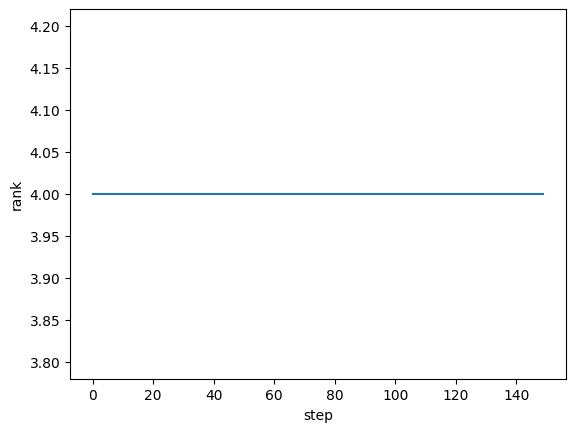

In [8]:
# plot observability matrix rank over time:
if 1:
    rank_log = np.zeros(n_steps)
    for i in range(n_steps):
        H = total_linear_measurement_matrix(x[:,0])
        O, rank = calculate_observability_matrix(A,H)
        
        rank_log[i] = rank
    # print(O)
    # calculate the eigenvalues of the observability matrix to find witch states are observable
    eigvals, eigvecs = np.linalg.eig(O.T@O)
    # print(eigvals)
    # null space of the observability matrix
    null_space = linalg.null_space(O)
    print(null_space)
    plt.plot(rank_log)
    plt.xlabel('step')
    
    plt.ylabel('rank')
    plt.show()